In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline




In [2]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    
    

In [3]:
def zscore(df, name):
    xmean = df[name].mean()
    xstd = np.std(df[name])
    result = (df[name]-xmean)/xstd
    df[name] = result


In [4]:
def update_cabin(df):
    cabin = df["Cabin"]
    tmp = []
    for i in range(len(cabin)):
        if type(cabin[i]) is str:
            tmp.append(1)
        else :
            tmp.append(0)
    df["Cabin"] = tmp

In [5]:
def make_age(df):
    tmp = []
    for i in range(len(df)):
        if math.isnan(df.iloc[i]["Age"]):
            tmp.append(25 if df.iloc[i]["Sex"] == 1 else 50)
        else :
            tmp.append(df.iloc[i]["Age"])
    df["Age"] = tmp

In [6]:
def make_family(df):
    tmp = []
    for i in range(len(df)):
        tmp.append(df.iloc[i]["SibSp"] + df.iloc[i]["Parch"])
    df["FamilySize"] = tmp

In [7]:
def make_is_alone(df):
    tmp = []
    for i in range(len(df)):
        tmp.append(1 if df.iloc[i]["SibSp"] + df.iloc[i]["Parch"] == 0 else 0)
    df["IsAlone"] = tmp

In [48]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
corr_matrix = train_data.corr()

In [13]:
corr_matrix["Fare"].sort_values()

Pclass        -0.549500
PassengerId    0.012658
Age            0.096067
SibSp          0.159651
Parch          0.216225
Survived       0.257307
Fare           1.000000
Name: Fare, dtype: float64

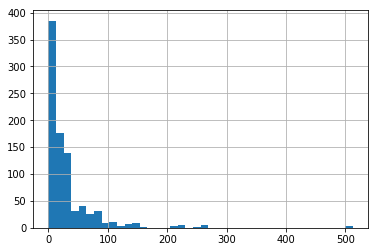

In [18]:
train_data["Fare"].hist(bins=20)

In [28]:
train_data["FarePerPerson"] = train_data["Fare"]/(train_data["Parch"] + train_data["SibSp"] + 1)

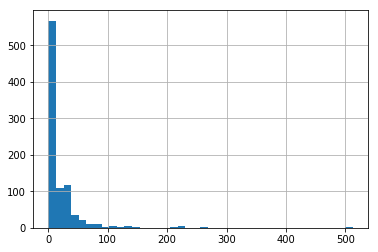

In [32]:
train_data["FarePerPerson"].hist(bins=40)

In [34]:
corr_matrix = train_data.corr()

In [36]:
corr_matrix["Survived"].sort_values()

Pclass          -0.338481
Age             -0.077221
SibSp           -0.035322
PassengerId     -0.005007
Parch            0.081629
FarePerPerson    0.221600
Fare             0.257307
Survived         1.000000
Name: Survived, dtype: float64

In [49]:

train_data.Embarked = train_data.Embarked.fillna(2.0)
train_data_age_mean = train_data.Age.mean()
train_data.Age = train_data.fillna(train_data.Age.mean())
train_data = train_data.replace('male', 0).replace('female', 1).replace('C', 0).replace('Q', 1).replace('S', 2)
#make_age(train_data)
make_family(train_data)
make_is_alone(train_data)
train_data.drop(['PassengerId', 'Name', 'Ticket', "SibSp", "Parch"], axis=1, inplace=True)
train_data.dropna()

train_data.Cabin = train_data.Cabin.fillna(0)
update_cabin(train_data)
zscore(train_data, "Age")
zscore(train_data, "Fare")

train_data.head()


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone
0,0,3,0,-1.730108,-0.502445,0,2.0,1,0
1,1,1,1,-1.726220,0.786845,1,0.0,1,0
2,1,3,1,-1.722332,-0.488854,0,2.0,0,1
3,1,1,1,-1.718444,0.420730,1,2.0,1,0
4,0,3,0,-1.714556,-0.486337,0,2.0,0,1


In [50]:
train_set, test_set = split_train_test(train_data, 0.2)


In [51]:
corr_matrix = train_set.corr()

In [52]:
corr_matrix["Survived"].sort_values()

Pclass       -0.319763
IsAlone      -0.182359
Embarked     -0.153786
FamilySize    0.004704
Age           0.016849
Fare          0.245787
Cabin         0.302648
Sex           0.542886
Survived      1.000000
Name: Survived, dtype: float64

In [11]:
train_set.describe()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone
count,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000
mean,0.377279,2.330996,0.345021,0.006303,0.007244,0.224404,1.565217,0.934081,0.601683
std,0.485046,0.824387,0.475709,0.999470,1.045724,0.417482,0.772797,1.681819,0.489895
min,0.000000,1.000000,0.000000,-1.730108,-0.648422,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,-0.863110,-0.488854,0.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.027215,-0.357391,0.000000,2.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,0.882549,-0.034314,0.000000,2.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,1.730108,9.667167,1.000000,2.000000,10.000000,1.000000


In [12]:
test_set.describe()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.410112,2.219101,0.382022,-0.025249,-0.029018,0.247191,1.421348,0.786517,0.606742
std,0.493241,0.878028,0.487253,1.007353,0.796225,0.432596,0.855025,1.301645,0.489851
min,0.000000,1.000000,0.000000,-1.710669,-0.648422,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,-0.873802,-0.489442,0.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,-0.081646,-0.356888,0.000000,2.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,0.820343,0.005054,0.000000,2.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,1.726220,4.634417,1.000000,2.000000,6.000000,1.000000


In [13]:
test_set

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone
709,1,3,0,1.026401,-0.341452,0,0.0,2,0
439,0,2,0,-0.023327,-0.437007,0,2.0,0,1
840,0,3,0,1.535714,-0.488854,0,2.0,0,1
720,1,2,1,1.069168,0.016023,0,2.0,1,0
39,1,3,1,-1.578481,-0.422074,0,0.0,1,0
290,1,1,1,-0.602622,0.939198,0,2.0,0,1
300,1,3,1,-0.563743,-0.492378,0,1.0,0,1
333,0,3,0,-0.435443,-0.285997,0,2.0,2,0
208,1,3,1,-0.921428,-0.492378,0,1.0,0,1
136,1,1,1,-1.201356,-0.119216,1,2.0,2,0


In [14]:
sample_x = train_set.drop(['Survived'], axis=1)
sample_y = train_set.drop(["Pclass", "Age", "FamilySize", "IsAlone", "Fare", "Cabin", "Embarked", "Sex"], axis=1)

In [15]:
rf = RandomForestClassifier(min_samples_leaf=1, random_state=0)
rf.fit(sample_x, sample_y.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
test_sample_x = test_set.drop(['Survived'], axis=1)
test_sample_y = test_set.drop(["Pclass", "Age", "FamilySize", "IsAlone", "Fare", "Embarked", "Sex"], axis=1)

rf_result = rf.predict(test_sample_x)

print("Result from Random Forrest")
print(np.sum(rf_result == test_sample_y['Survived']))
print(np.sum(rf_result == test_sample_y['Survived']) / len(rf_result))

Result from Random Forrest
136
0.7640449438202247


In [17]:
scores = cross_val_score(rf, sample_x, sample_y.values.ravel(), scoring="neg_mean_squared_error", cv = 10)
rf_rmse_scores = np.sqrt(-scores)

In [18]:
def display_scores(scores):
    print("Scores", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [19]:
display_scores(rf_rmse_scores)

Scores [0.372678   0.54006172 0.5        0.35355339 0.50350881 0.51730613
 0.54385168 0.48932261 0.51730613 0.39641248]
Mean: 0.4734000964831294
Standard deviation: 0.06750226749367837


In [20]:
# random forest
param_grid = [
        {
            'n_estimators': [3, 10, 15, 20, 25, 30], 
            'max_depth': [3, 5, 10, 15, 20],
    },
    {
        'bootstrap': [False], 
        'n_estimators': [3, 10, 15, 20, 25, 30], 
        'max_depth': [3, 5, 10, 15, 20],
    },
]

rf_grid_search = GridSearchCV(rf, param_grid, cv = 11,scoring = 'accuracy')

rf_grid_search.fit(sample_x, sample_y.values.ravel())

GridSearchCV(cv=11, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 15, 20, 25, 30], 'max_depth': [3, 5, 10, 15, 20]}, {'bootstrap': [False], 'n_estimators': [3, 10, 15, 20, 25, 30], 'max_depth': [3, 5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
rf_grid_search.best_params_

{'max_depth': 5, 'n_estimators': 30}

In [22]:
rf_grid_result = rf_grid_search.predict(test_sample_x)

print("Result from grid seasrched random forest")
print(np.sum(rf_grid_result==test_sample_y['Survived']))
print(np.sum(rf_grid_result == test_sample_y['Survived']) / len(rf_grid_result))

Result from grid seasrched random forest
145
0.8146067415730337


In [23]:
print(rf_grid_search.best_score_)

0.8022440392706872


In [24]:
test_data = pd.read_csv("test.csv")
make_family(test_data)
make_is_alone(test_data)
test_data = test_data.replace('male', 0).replace('female', 1).replace('C', 0).replace('Q', 1).replace('S', 2)
test_data.Embarked = test_data.Embarked.fillna(2.0)
test_data.Fare = test_data.Fare.fillna(0) # to be dead
test_data.Age = test_data.Age.fillna(train_data_age_mean)

test_data.Cabin = test_data.Cabin.fillna(0)
update_cabin(test_data)
zscore(test_data, "Age")
zscore(test_data, "Fare")

ids = test_data['PassengerId']
test_data.drop(['PassengerId',  'Name', 'Ticket', "SibSp", "Parch"], axis=1, inplace=True)
test_data.head()


,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize,IsAlone
0,3,0,0.344284,-0.496637,0,1,0,1
1,3,1,1.334655,-0.511497,0,2,1,0
2,2,0,2.523099,-0.463335,0,1,0,1
3,3,0,-0.249938,-0.481704,0,2,0,1
4,3,1,-0.646086,-0.416740,0,2,2,0


In [25]:
output = pd.DataFrame(columns=["PassengerId","Survived"])


for i in range(len(ids)) :
    row = test_data[i:i+1]
    predicted = rf_grid_search.predict(row)
    insert = pd.Series([ids[i], predicted[0]], index=output.columns)
    output = output.append(insert, ignore_index=True)

#    df = pd.DataFrame([[ids[i], predicted[0]]], columns=["PassengerId","Survived"])
#    output = output.append(df, ignore_index=True)
#print(output)

In [26]:
output.describe()

,PassengerId,Survived
count,418,418
unique,418,2
top,1023,0
freq,1,274


In [27]:
output.to_csv('modified_RandomFresst_gridsearch.csv', index=False)